## Laboratory of Computational Physics mod. B at Phisics of Data, University of Padova

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

### Description 
---
> The goal of this project is to find the branching ratio of 
$B^0 \rightarrow \eta' K_S^0$

with :  
$\eta' \rightarrow \eta \; \pi^+ \pi^-$, <br>
$\eta \rightarrow \gamma \gamma$ and <br>
$K_S^0 \rightarrow \pi^+ \pi^-$<br>
in Monte Carlo simulation (Data Challenge)

To do this, we build a deep neural network (DNN) with Keras/Tensorflow using labelled data, optimize it and finally use it as a classifier on the Data Challenge

In [197]:
import os, sys, pprint
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [198]:
Testing = False # Uses only a small subset of the data and trains on fewer epochs. 
PCA_ON = False
Local_Philipp = False
Local_Valeria = False
VM = True

if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

Paths are set to run on the VM


## 1. Reading and Cleaning Data

In this chapter we
- read relevant information from root files into pandas data frames
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [199]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [200]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")

In [201]:
%%time
from root_pandas import read_root

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    path = '/home/Students/DataBelle2_all/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    
elif Local_Matteo:  
    path = '/home/guida/Scrivania/PROJECT_2/DataBelle2'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    
elif Local_Valeria:  
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

print ("Memory used by Signal", memory(Signal))
print ("Memory used by Continuum", memory(Continuum_bkg))
print ("Memory used by Peaking \n", memory(Peaking_bkg))

print("Peaking shape : ",Peaking_bkg.shape)
print("Continuum shape : ",Continuum_bkg.shape)
print("Signal shape : ",Signal.shape)

71.3 Mb
Memory used by Signal None
77.18 Mb
Memory used by Continuum None
0.49 Mb
Memory used by Peaking 
 None
Peaking shape :  (1490, 85)
Continuum shape :  (232554, 85)
Signal shape :  (219897, 85)
CPU times: user 22.1 s, sys: 481 ms, total: 22.6 s
Wall time: 22.6 s


### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of background

In [202]:
"""#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print("Signal : ",Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print("Continuum : ", Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print("Peaking : ",Peaking_bkg.shape)

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print("Signal : ",Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]
"""

'#Masses from PDG\nM_B0 = [5.27955, 0.00026]\nM_K0 = [0.497611, 0.000013]\nM_etap = [0.95778, 0.00006]\nM_eta = [0.547862, 0.000017]\n\n#Require the B0 mass to be within 5 sigma from PDG value\nSignal = Signal[abs(Signal[\'B0_M\'] - M_B0[0]) < 5 * Signal[\'B0_ErrM\']]\nprint("Signal : ",Signal.shape)\n\nContinuum_bkg = Continuum_bkg[abs(Continuum_bkg[\'B0_M\'] - M_B0[0]) < 5 * Continuum_bkg[\'B0_ErrM\']]\nprint("Continuum : ", Continuum_bkg.shape)\n\nPeaking_bkg = Peaking_bkg[abs(Peaking_bkg[\'B0_M\'] - M_B0[0]) < 5 * Peaking_bkg[\'B0_ErrM\']]\nprint("Peaking : ",Peaking_bkg.shape)\n\n#Signal: In case of more than 1 candidate per event select the first one occuring\nMask_duplicated = Signal.duplicated(subset=\'evt_no\', keep=\'first\')\nMask_duplicated=np.logical_not(Mask_duplicated)\nSignal=Signal[Mask_duplicated]\nSignal.reset_index(drop=True, inplace=True)\n\nprint("Signal : ",Signal.shape)\nprint(Signal[\'evt_no\'].nunique())\n\nSignal=Signal[Training]\nContinuum_bkg=Continuum_bkg[

In [203]:
# lines_selected=50000
# Signal=Signal[0:lines_selected]
# Continuum_bkg=Continuum_bkg[0:lines_selected]

memory(Signal)
memory(Continuum_bkg)
memory(Peaking_bkg)
print("Peaking : ",Peaking_bkg.shape)
print("Continuum : ",Continuum_bkg.shape)
print("Signal : ",Signal.shape)
print("% of peaking on the entire dataset : ",round((Peaking_bkg.shape[0])/(Peaking_bkg.shape[0]+Continuum_bkg.shape[0]+Signal.shape[0])*100,3))

71.3 Mb
77.18 Mb
0.49 Mb
Peaking :  (1490, 85)
Continuum :  (232554, 85)
Signal :  (219897, 85)
% of peaking on the entire dataset :  0.328


## 2. Data Preprocessing

In this chapter we
- label our data
- turn the label into one-hot vectors as this format is needed by Keras
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) to assure to have a fair amount of each type in all sets
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the principal components necessary for 99% of the variance

In [204]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [205]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

In [206]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

"""del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)"""


'del(Signal)\ndel(Peaking_bkg)\ndel(Continuum_bkg)'

In [207]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

print(X_Train.shape)
print(X_Validation.shape)
print(X_Test.shape)

print("X Train shape : ", X_Train.shape)
print("X Validation shape : ",X_Validation.shape)
print("X Test shape : ",X_Test.shape)
n_classes = Y_Train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

(226970, 85)
(136182, 85)
(90789, 85)
X Train shape :  (226970, 85)
X Validation shape :  (136182, 85)
X Test shape :  (90789, 85)


In [208]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

In [209]:
"""from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = pd.DataFrame(ss.fit_transform(X_Train),columns = X_Train.columns)
X_Test = pd.DataFrame(ss.fit_transform(X_Test),columns = X_Test.columns)
X_Validation = pd.DataFrame(ss.fit_transform(X_Validation),columns = X_Validation.columns)"""

'from sklearn.preprocessing import StandardScaler\n\nss = StandardScaler()\nX_Train = pd.DataFrame(ss.fit_transform(X_Train),columns = X_Train.columns)\nX_Test = pd.DataFrame(ss.fit_transform(X_Test),columns = X_Test.columns)\nX_Validation = pd.DataFrame(ss.fit_transform(X_Validation),columns = X_Validation.columns)'

## PCA

Principal component analysis is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise.

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

In [210]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

if PCA_ON : 
    pca = PCA(n_components=len(Training))
    pcTrain = pd.DataFrame(data = pca.fit_transform(X_Train))
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

    T50, T90, T95, T99, = False, False, False, False
    for i in range(len(pca.explained_variance_ratio_)) : 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
            print(str(i+1) + ' variables explain 50% of the variance')
            T50 = True
            n_50 = i + 1 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
            print(str(i+1) + ' variables explain 90% of the variance')
            T90 = True
            n_90 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
            print(str(i+1) + ' variables explain 95% of the variance')
            T95 = True
            n_95 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
            print(str(i+1) + ' variables explain 99% of the variance')
            T99 = True
            n_99 = i + 1
        
    plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
    plt.title('PCA on the dataset',fontsize=20)
    plt.xlabel('Number of Components [#]',fontsize=20)
    plt.tick_params(labelsize=14)
    fig.set_size_inches(6, 6)
    plt.ylabel('Explained Variance [%]',fontsize=20)
    plt.show()
    joblib.dump(pca, 'PCA.pkl')
    
else : 
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation

In [211]:
if PCA_ON : 
    pca = PCA(n_components=n_99)
    pcTrain = pca.fit_transform(X_Train)
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))
    print ("Input Dimension has been reduced to ", n_99)
else : 
    input_dim = 83
    print("Input Dimension has not been reduced")

Input Dimension has not been reduced


## 3. Create the Neural Network 

In [212]:
#optimizer = ['SGD', 'Adam']
optimizer = ['SGD']
#epochs = [10, 30]
epochs = [10]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]
# architectures = [ [50, 50], [50, 100, 50], [50, 100, 100, 50] ] 
architectures = [[50, 100,100,50]] 
#activation = ['relu', 'elu']
activation = ['elu']

In [213]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='elu'):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='elu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='elu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))


In [214]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=10000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8,cv=5)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [50, 100, 100, 50]
Epoch 1/10
181576/181576 [==============================] - 14s 78us/step - loss: 0.0393 - acc: 0.9895
Epoch 2/10
181576/181576 [==============================] - 9s 52us/step - loss: 0.0280 - acc: 0.9933
Epoch 3/10
181576/181576 [==============================] - 9s 50us/step - loss: 0.0252 - acc: 0.9938
Epoch 4/10
181576/181576 [==============================] - 9s 49us/step - loss: 0.0246 - acc: 0.9942
Epoch 5/10
181576/181576 [==============================] - 9s 50us/step - loss: 0.0241 - acc: 0.9943
Epoch 6/10
181576/181576 [==============================] - 9s 50us/step - loss: 0.0231 - acc: 0.9944
Epoch 7/10
181576/181576 [==============================] - 9s 50us/step - loss: 0.0227 - acc: 0.9947
Epoch 8/10
181576/181576 [==============================] - 9s 51us/step - loss: 0.0228 - acc: 0.9947
Epoch 9/10
181576/181576 [==============================] - 9s 50us/step - loss: 0.0213 - acc: 0.9950
Epoch 10/10
45394/45394 [================

181576/181576 [==============================] - 2s 11us/step - loss: 0.0258 - acc: 0.9937
Epoch 7/10
181576/181576 [==============================] - 2s 11us/step - loss: 0.0252 - acc: 0.9940
Epoch 8/10
181576/181576 [==============================] - 2s 11us/step - loss: 0.0253 - acc: 0.9939
Epoch 9/10
181576/181576 [==============================] - 2s 11us/step - loss: 0.0238 - acc: 0.9942
Epoch 10/10
45394/45394 [==============================] - 3s 63us/step
Epoch 1/10
181576/181576 [==============================] - 8s 42us/step - loss: 0.0718 - acc: 0.9793
Epoch 2/10
181576/181576 [==============================] - 2s 11us/step - loss: 0.0319 - acc: 0.9924
Epoch 3/10
181576/181576 [==============================] - 2s 11us/step - loss: 0.0285 - acc: 0.9930
Epoch 4/10
181576/181576 [==============================] - 2s 11us/step - loss: 0.0274 - acc: 0.9934
Epoch 5/10
181576/181576 [==============================] - 2s 11us/step - loss: 0.0264 - acc: 0.9936
Epoch 6/10
181576/181

In [215]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9973432637539373
{'activation': 'elu', 'batch_size': 100, 'epochs': 10, 'optimizer': 'SGD'}


### Evaluate the best Network

In [216]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]
layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = Best_Params['epochs'])

Epoch 1/10
226970/226970 [==============================] - 19s 84us/step - loss: 0.0368 - acc: 0.9906
Epoch 2/10
226970/226970 [==============================] - 12s 54us/step - loss: 0.0272 - acc: 0.9936
Epoch 3/10
226970/226970 [==============================] - 12s 53us/step - loss: 0.0258 - acc: 0.9939
Epoch 4/10
226970/226970 [==============================] - 12s 53us/step - loss: 0.0240 - acc: 0.9942
Epoch 5/10
226970/226970 [==============================] - 12s 54us/step - loss: 0.0238 - acc: 0.9945
Epoch 6/10
226970/226970 [==============================] - 12s 54us/step - loss: 0.0230 - acc: 0.9944
Epoch 7/10
226970/226970 [==============================] - 12s 53us/step - loss: 0.0222 - acc: 0.9947
Epoch 8/10
226970/226970 [==============================] - 12s 53us/step - loss: 0.0220 - acc: 0.9948
Epoch 9/10
226970/226970 [==============================] - 12s 53us/step - loss: 0.0208 - acc: 0.9951
Epoch 10/10
226970/226970 [==============================] - 12s 52us/ste

In [217]:
Best_Model.evaluate(pcTrain, Y_Train)

226970/226970 [==============================] - 23s 102us/step


[0.012182675592822302, 0.9974666255452262]

In [218]:
train_prediction = Best_Model.predict(pcTrain)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

In [219]:
N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if train_pred[i].all() == Y_Train[i].all() : N_true += 1
    else : N_false += 1
        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Accuracy =  1.0
N_true:  226970
N_false:  0


In [220]:
print(Best_Model.evaluate(pcTrain, Y_Train))
print(Best_Model.evaluate(pcValidation, Y_Validation))

226970/226970 [==============================] - 21s 92us/step
[0.012182675592822302, 0.9974666255452262]
136182/136182 [==============================] - 12s 91us/step
[0.012865415426267394, 0.9973564788298013]


In [221]:
train_prediction = Best_Model.predict(pcValidation)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(Y_Validation[i], train_pred[i]) : N_true += 1
    else : N_false += 1
        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Accuracy =  0.9973564788298013
N_true:  135822
N_false:  360


In [222]:
print("Trainig Error : ",1-Best_Model.evaluate(pcTrain, Y_Train)[1])
print("Validation Error : ",1-Best_Model.evaluate(pcValidation, Y_Validation)[1])

226970/226970 [==============================] - 21s 91us/step
Trainig Error :  0.0025333744547737513
136182/136182 [==============================] - 12s 91us/step
Validation Error :  0.002643521170198726


In [223]:
y_score = Best_Model.predict(pcValidation)

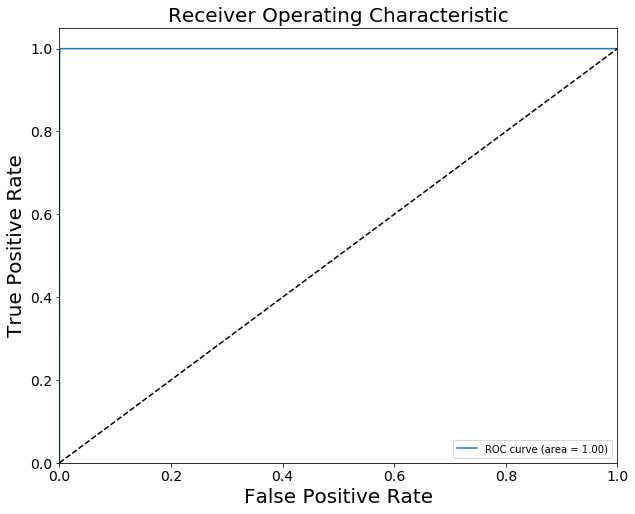

In [224]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
fig = plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.tick_params(labelsize=14)
plt.legend(loc="lower right")
fig.set_size_inches(10, 8)
plt.show()

### Confusion Matrix

In [225]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.ylabel('TRUE LABEL',fontsize=20)
    plt.xlabel('PREDICTED LABEL',fontsize=20)
    fig.set_size_inches(10, 8)
    plt.tight_layout()

In [226]:
from sklearn.metrics import confusion_matrix

#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_val_predict = Best_Model.predict_proba(X_Validation)
Y_val_single_col = np.where(Y_Validation==1)[1]
Y_val_mo = pd.get_dummies(Y_val_single_col[:])
Y_val_predict_mo = Y_val_predict.round()
cnf_matrix = confusion_matrix(Y_val_mo.values.argmax(axis=1), Y_val_predict_mo.argmax(axis=1))

In [227]:
print(pd.value_counts(Y_val_predict_mo.argmax(axis=1)))

1    69989
2    66018
0      175
dtype: int64


In [228]:
cnf_matrix

array([[  132,   262,    53],
       [   41, 69725,     0],
       [    2,     2, 65965]])

Normalized confusion matrix
[[2.95302013e-01 5.86129754e-01 1.18568233e-01]
 [5.87678812e-04 9.99412321e-01 0.00000000e+00]
 [3.03172702e-05 3.03172702e-05 9.99939365e-01]]


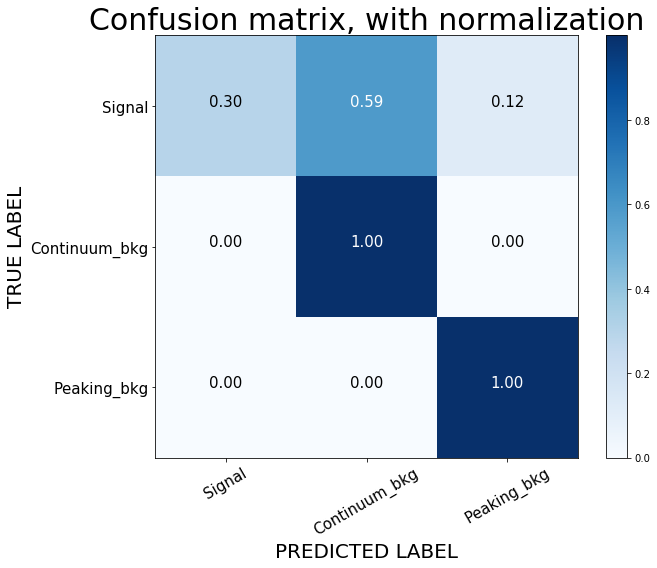

In [229]:
import itertools
plot_confusion_matrix(cnf_matrix, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title='Confusion matrix, with normalization')

### Confusion Matrix Training Set

In [230]:
#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_train_predict = Best_Model.predict_proba(X_Train)
Y_train_single_col = np.where(Y_Train==1)[1]
Y_train_mo = pd.get_dummies(Y_train_single_col[:])
Y_train_predict_mo = Y_train_predict.round()
cnf_matrix_train = confusion_matrix(Y_train_mo.values.argmax(axis=1), Y_train_predict_mo.argmax(axis=1))

In [231]:
cnf_matrix_train

array([[   234,    426,     85],
       [    55, 116222,      0],
       [     0,      7, 109941]])

Confusion Matrix for Ttraining set
Normalized confusion matrix
[[3.14093960e-01 5.71812081e-01 1.14093960e-01]
 [4.73008420e-04 9.99526992e-01 0.00000000e+00]
 [0.00000000e+00 6.36664605e-05 9.99936334e-01]]


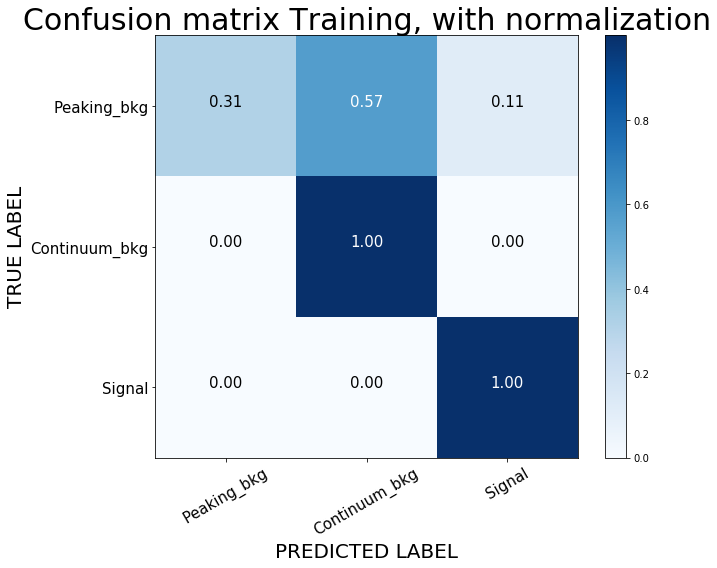

In [232]:
print("Confusion Matrix for Ttraining set")
plot_confusion_matrix(cnf_matrix_train, classes=['Peaking_bkg', 'Continuum_bkg', 'Signal'],
                       title='Confusion matrix Training, with normalization')

### Store the Weights

In [108]:
Best_Model.save("Best_Model.h5")

In [109]:
Best_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_34 (Dropout)         (None, 85)                0         
_________________________________________________________________
dense_166 (Dense)            (None, 50)                4300      
_________________________________________________________________
dense_167 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_168 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_169 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_170 (Dense)            (None, 3)                 153       
Total params: 24,703
Trainable params: 24,703
Non-trainable params: 0
_________________________________________________________________


### Try Loading the model

In [110]:
!ls

anaconda3			   Keras_Analysis-Copy2.ipynb
Anaconda3-2019.03-Linux-x86_64.sh  Keras_Analysis-Copy3.ipynb
ANALISIS_1.ipynb		   Keras_Analysis.ipynb
ANALYSIS1.ipynb			   Models
ANALYSIS-Copy1.ipynb		   Philipp
ANALYSIS.ipynb			   Quitegood-Copy1.ipynb
Belle-II-analysis		   Quitegood-Copy2.ipynb
Best_Model.h5			   Quitegood.ipynb
DataBelle2_all			   TIDY.ipynb
environment.yml			   Untitled.ipynb
Keras_Analysis-Copy1.ipynb	   Xgboost all step.ipynb


In [111]:
from keras.models import load_model

Loaded_Model = load_model('Best_Model.h5')
Loaded_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_34 (Dropout)         (None, 85)                0         
_________________________________________________________________
dense_166 (Dense)            (None, 50)                4300      
_________________________________________________________________
dense_167 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_168 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_169 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_170 (Dense)            (None, 3)                 153       
Total params: 24,703
Trainable params: 24,703
Non-trainable params: 0
_________________________________________________________________


In [112]:
X_Train.values

array([[ 0.00000000e+00, -1.86729447e-01, -9.17715900e-01, ...,
        -2.75230341e-01,  8.02541192e-01, -2.10954134e-01],
       [ 0.00000000e+00, -4.91743079e-01,  1.09585068e+00, ...,
        -4.08086685e-01,  9.46410607e-01,  2.07657381e-01],
       [ 0.00000000e+00, -8.57135952e-02, -8.59905893e-01, ...,
         2.22162052e-01, -5.61916734e-01, -4.08781090e-01],
       ...,
       [ 0.00000000e+00, -3.02368993e-01,  1.76428995e+00, ...,
        -1.33682100e-03, -1.93912435e+00, -5.85777477e-02],
       [ 0.00000000e+00,  2.43159206e+00, -2.62753578e-01, ...,
        -3.65888059e-01,  1.31448442e+00,  3.58515984e-02],
       [ 0.00000000e+00, -5.67025838e-01, -3.51500001e-01, ...,
        -3.58643740e-01,  2.09414983e+00, -4.90527974e-01]])

In [113]:
Loaded_Model.evaluate(pcTest, Y_Test, verbose=1)

90789/90789 [==============================] - 8s 93us/step


[0.7129355608635048, 0.5125620945275265]

## XGBOOST

In [236]:
%%time
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier


Y_Train_single_col=np.where(Y_Train==1)[1]
Y_Test_single_col=np.where(Y_Test==1)[1]
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1,num_class=3, max_depth=5,seed=1432,n_estimators=100,n_jobs = 1,objective = 'multi:softmax',silent=1,tree_method='approx')
XGBclassifier.fit(X_Train, Y_Train_single_col)
y_pred= XGBclassifier.predict(X_Test)
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_Test, Y_Test_single_col)))

Model Accuracy with all features: 99.80%
CPU times: user 10min 44s, sys: 0 ns, total: 10min 44s
Wall time: 10min 46s


In [237]:
cnf_matrix_xg = confusion_matrix(Y_Test_single_col,y_pred)
cnf_matrix_xg

array([[  118,   179,     1],
       [    5, 46506,     0],
       [    0,     0, 43980]])

Normalized confusion matrix
[[3.95973154e-01 6.00671141e-01 3.35570470e-03]
 [1.07501451e-04 9.99892499e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


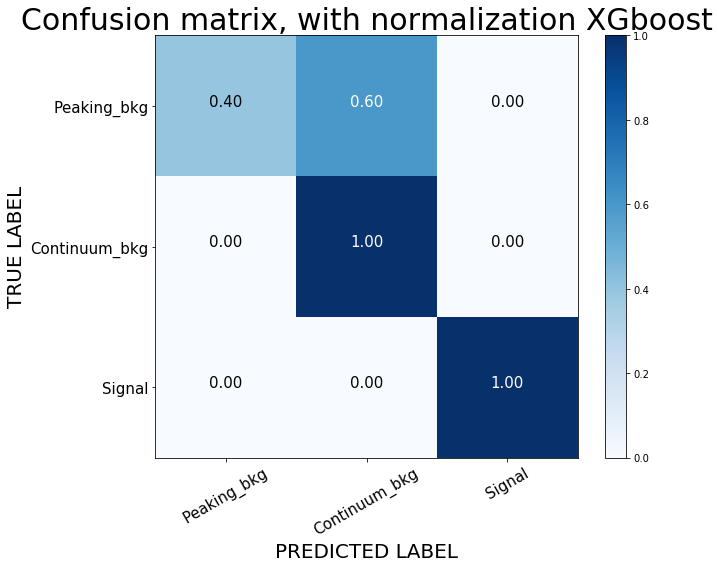

In [240]:
import itertools
plot_confusion_matrix(cnf_matrix_xg, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title='Confusion matrix, with normalization XGboost')

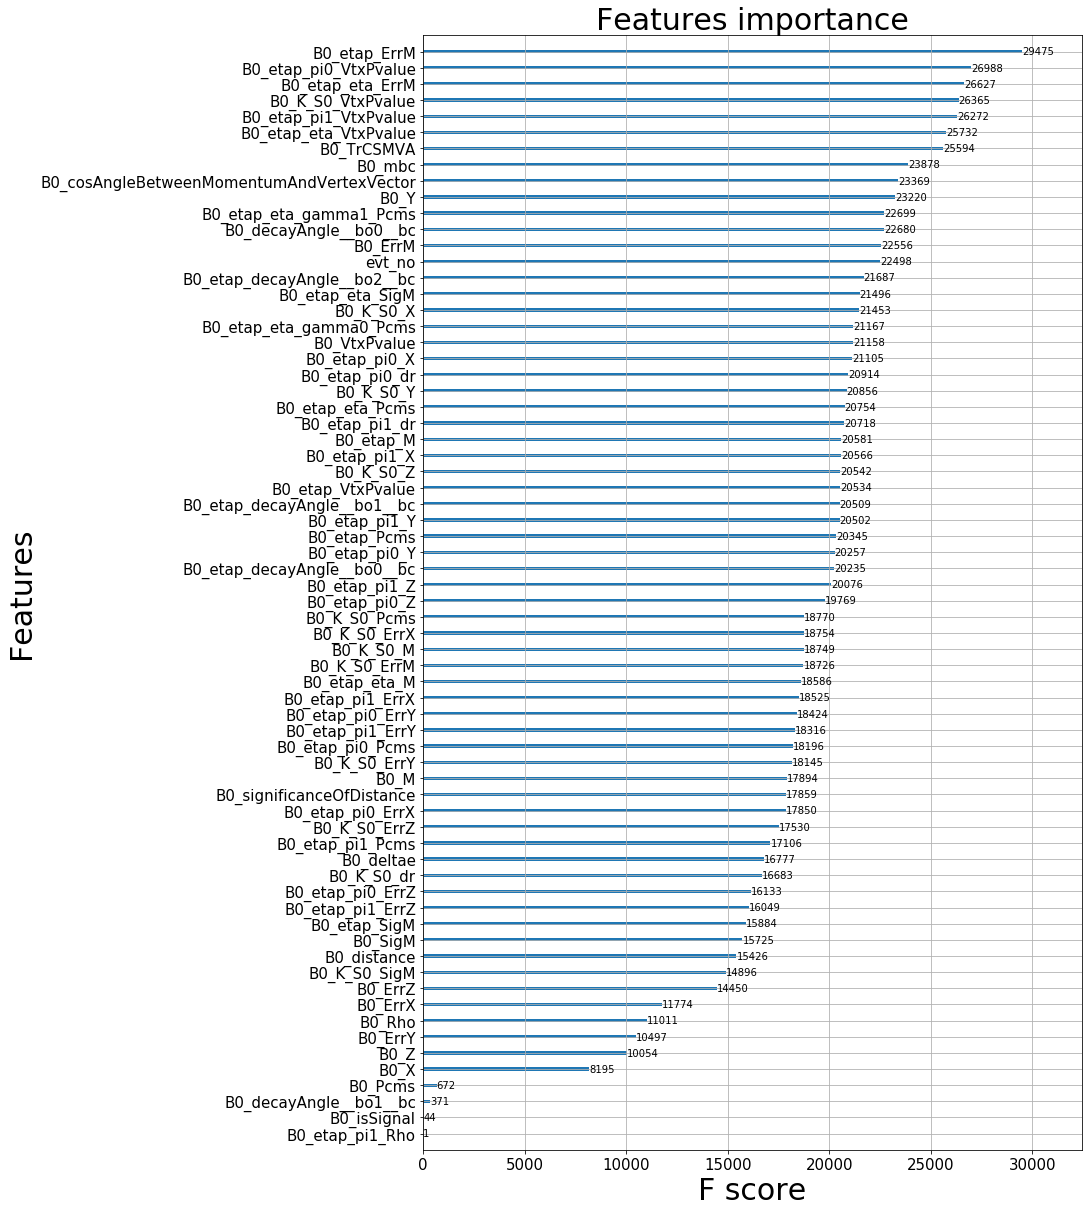

In [27]:
fig=plt.figure()
fig.set_size_inches(30.5, 20.5)
plt.tick_params(labelsize=15)
xgb.plot_importance(XGBclassifier, ax=plt.gca())
plt.title("Features importance",fontsize=30)
plt.ylabel("Features",fontsize=30)
plt.xlabel("F score",fontsize=30)
fig.subplots_adjust(left=0.6)  #
#fig.savefig('SUSYXGBoost1.pdf')